In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

matplotlib.rcParams['figure.facecolor'] = 'w'

In [6]:
from csgan.util.color import color_gray_image
from csgan.loader.colored_mnist_loader import ColoredMnistDataset

In [9]:
DATA_ROOT = os.path.join(__ROOT_PATH, "data/")

In [69]:
mnist_train_dataset = torchvision.datasets.MNIST(root=DATA_ROOT, train=True, download=True,
                                                 transform=torchvision.transforms.ToTensor())
mnist_test_dataset = torchvision.datasets.MNIST(root=DATA_ROOT, train=False, download=True,
                                                transform=torchvision.transforms.ToTensor())

In [70]:
train_images, train_labels = list(zip(*mnist_train_dataset))
train_images = torch.cat(train_images, dim=0).unsqueeze(-1).expand(-1, -1, -1, 3).numpy()
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

test_images, test_labels = list(zip(*mnist_test_dataset))
test_images = torch.cat(test_images, dim=0).unsqueeze(-1).expand(-1, -1, -1, 3).numpy()
test_labels = np.array(test_labels)
print(test_images.shape, test_labels.shape)

(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)


In [72]:
train_gray_images = np.zeros_like(train_images)
train_colored_images = np.zeros_like(train_images)
train_white_colors = []
train_black_colors = []
for iimage, image in enumerate(train_images):
    random_white_color = (0, 0, 0)
    while random_white_color[0] + random_white_color[1] + random_white_color[2] < 2 * 255:
        random_white_color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    random_black_color = (255, 255, 255)
    while (random_black_color[0] + random_black_color[1] + random_black_color[2] > 255):
        random_black_color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    train_gray_images[iimage] = color_gray_image(image, (255, 255, 255), random_black_color)
    train_colored_images[iimage] = color_gray_image(image, random_white_color, random_black_color)
    train_white_colors.append(list(random_white_color))
    train_black_colors.append(list(random_black_color))
train_white_colors = np.array(train_white_colors)
train_black_colors = np.array(train_black_colors)
print(train_colored_images.shape, train_white_colors.shape, train_black_colors.shape)

test_gray_images = np.zeros_like(test_images)
test_colored_images = np.zeros_like(test_images)
test_white_colors = []
test_black_colors = []
for iimage, image in enumerate(test_images):
    random_white_color = (0, 0, 0)
    while random_white_color[0] + random_white_color[1] + random_white_color[2] < 2 * 255:
        random_white_color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    random_black_color = (255, 255, 255)
    while random_black_color[0] + random_black_color[1] + random_black_color[2] > 255:
        random_black_color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    test_gray_images[iimage] = color_gray_image(image, (255, 255, 255), random_black_color)
    test_colored_images[iimage] = color_gray_image(image, random_white_color, random_black_color)
    test_white_colors.append(list(random_white_color))
    test_black_colors.append(list(random_black_color))
test_white_colors = np.array(test_white_colors)
test_black_colors = np.array(test_black_colors)
print(test_colored_images.shape, test_white_colors.shape, test_black_colors.shape)

(60000, 28, 28, 3) (60000, 3) (60000, 3)
(10000, 28, 28, 3) (10000, 3) (10000, 3)


In [78]:
train_data = dict()
train_data['gray_image'] = train_gray_images
train_data['colored_image'] = train_colored_images
train_data['label'] = train_labels
train_data['white_color'] = train_white_colors
train_data['black_color'] = train_black_colors
np.savez(os.path.join(DATA_ROOT, 'colored_mnist_bg/train.npz'), **train_data)

test_data = dict()
test_data['gray_image'] = test_gray_images
test_data['colored_image'] = test_colored_images
test_data['label'] = test_labels
test_data['white_color'] = test_white_colors
test_data['black_color'] = test_black_colors
np.savez(os.path.join(DATA_ROOT, 'colored_mnist_bg/test.npz'), **test_data)

In [79]:
train_data = dict(np.load(os.path.join(DATA_ROOT, 'colored_mnist_bg/train.npz')))
test_data = dict(np.load(os.path.join(DATA_ROOT, 'colored_mnist_bg/test.npz')))

38987
8 [232 135 238] [89 40 19]


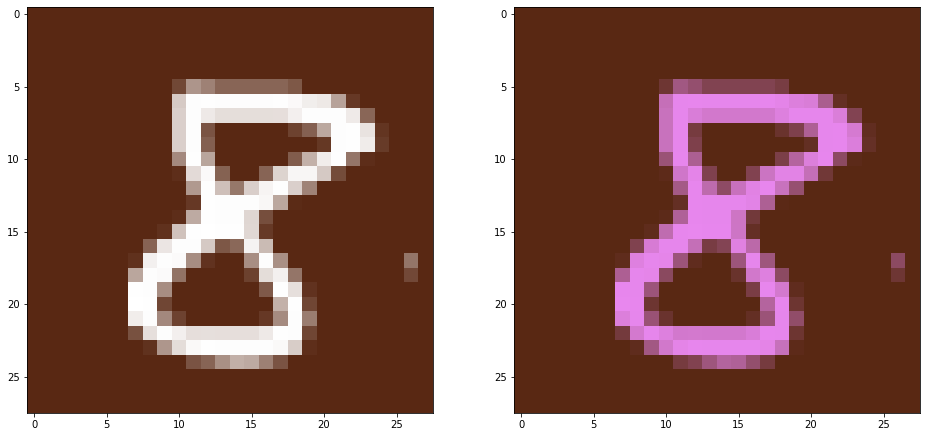

In [93]:
data = train_data
index = np.random.randint(len(data['label']))

print(index)
print(data['label'][index], data['white_color'][index], data['black_color'][index])

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(data['gray_image'][index])
ax = fig.add_subplot(1, 2, 2)
plt.imshow(data['colored_image'][index])
plt.show()

In [40]:
train_dataset = ColoredMnistDataset(root=DATA_ROOT, train=True)
test_dataset = ColoredMnistDataset(root=DATA_ROOT, train=False)
print(len(train_dataset), len(test_dataset))

60000 10000


In [363]:
from torch import nn

nn.MSELoss()(torch.ones(5, 2), torch.zeros(5, 2))

tensor(1.)

39363
0 4
[0. 0. 0.] [0.13333334 0.85490197 0.92941177]


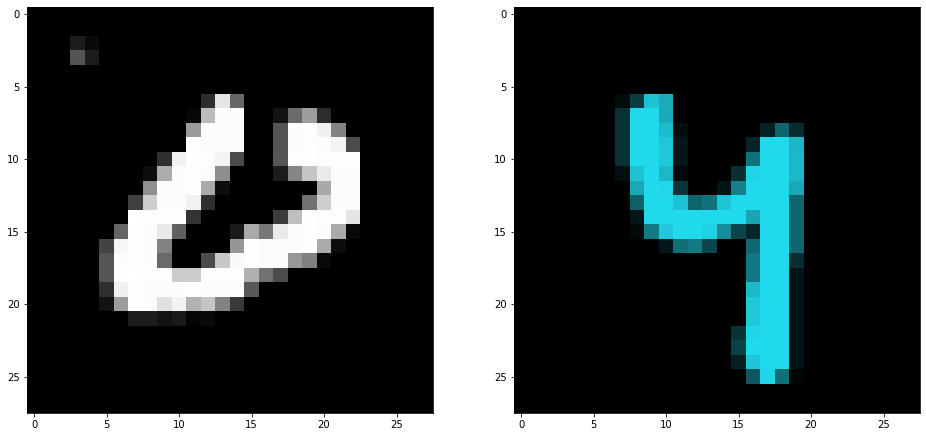

In [358]:
dataset = train_dataset
index = np.random.randint(len(dataset))

print(index)
print(dataset[index]['y1'].item(), dataset[index]['y2'].item())
print(dataset[index]['c1'].numpy(), dataset[index]['c2'].numpy())

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(dataset[index]['x1'].numpy().transpose(1, 2, 0))
ax = fig.add_subplot(1, 2, 2)
plt.imshow(dataset[index]['x2'].numpy().transpose(1, 2, 0))
plt.show()